In [996]:
import pyarrow
import dask.dataframe as dd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import seaborn as sns

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve, precision_recall_fscore_support, f1_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses, regularizers
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.models import Model, Sequential, load_model

from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [997]:
final_dataset_path = 'FEData_For_Modelling.parquet'

# Read the multi-part Parquet dataset
fds = dd.read_parquet(final_dataset_path)
fds.head(4000)

,user,O,C,E,A,N,FCwke,FCowh,FCwh,SDwke,SDowh,SDwh,CDwke,CDowh,CDwh,JDwke,JDowh,JDwh
0,AAB1302,38,41,10,38,28,23,37,142,0,1,10,0,0,0,40,81,246
1,AAB1762,32,39,18,18,33,0,194,654,0,9,14,0,0,4,0,243,679
2,AAC0904,31,30,36,18,28,0,0,0,0,22,144,0,5,34,0,499,4025
3,AAC1033,42,40,40,22,29,0,0,0,0,14,72,0,0,1,0,1,2
4,AAC1489,24,13,42,24,38,0,0,0,0,1,175,0,0,2,0,101,5058
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,ZRF1980,43,41,26,16,30,0,9,1272,0,16,298,0,0,11,0,28,494
1996,ZUR1449,31,42,12,36,17,0,0,0,0,1,7,0,65,296,0,293,1322
1997,ZVW1475,38,35,18,24,37,0,0,0,0,0,1,0,0,0,0,2,7
1998,ZWS0755,45,47,42,39,28,0,0,0,0,58,266,0,0,0,0,148,810


In [998]:
data = pd.read_parquet('FEData_For_Modelling.parquet').reset_index(drop = True)
data

,user,O,C,E,A,N,FCwke,FCowh,FCwh,SDwke,SDowh,SDwh,CDwke,CDowh,CDwh,JDwke,JDowh,JDwh
0,AAB1302,38,41,10,38,28,23,37,142,0,1,10,0,0,0,40,81,246
1,AAB1762,32,39,18,18,33,0,194,654,0,9,14,0,0,4,0,243,679
2,AAC0904,31,30,36,18,28,0,0,0,0,22,144,0,5,34,0,499,4025
3,AAC1033,42,40,40,22,29,0,0,0,0,14,72,0,0,1,0,1,2
4,AAC1489,24,13,42,24,38,0,0,0,0,1,175,0,0,2,0,101,5058
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,ZRF1980,43,41,26,16,30,0,9,1272,0,16,298,0,0,11,0,28,494
1996,ZUR1449,31,42,12,36,17,0,0,0,0,1,7,0,65,296,0,293,1322
1997,ZVW1475,38,35,18,24,37,0,0,0,0,0,1,0,0,0,0,2,7
1998,ZWS0755,45,47,42,39,28,0,0,0,0,58,266,0,0,0,0,148,810


In [1005]:
import os
malicious_filenames = os.listdir('answers/r5.2-2')
malicious_users = []

for filename in malicious_filenames:
    malicious_users.append(filename.replace('r5.2-2-', "").replace('.csv', ""))

malicious_users

['MDS0680',
 'GWG0497',
 'CKP0630',
 'HMS1658',
 'BYO1846',
 'HXP0976',
 'CIF1430',
 'ITA0159',
 'OSS1463',
 'SNK1280',
 'HIS1394',
 'SIS0042',
 'HSN0675',
 'MCP0611',
 'TNB1616',
 'CHP1711',
 'MGB1235',
 'NAH1366',
 'JAL0811',
 'OKM1092',
 'TMT0851',
 'DCC1119',
 'KSS1005',
 'VCF1602',
 'RRS0056',
 'WDT1634',
 'ICB1354',
 'ZIE0741',
 'LVF1626',
 'TRC1838']

In [1006]:
data['malicious'] = np.where(data['user'].isin(malicious_users), 1, 0)
data

,user,O,C,E,A,N,FCwke,FCowh,FCwh,SDwke,SDowh,SDwh,CDwke,CDowh,CDwh,JDwke,JDowh,JDwh,malicious
0,AAB1302,38,41,10,38,28,23,37,142,0,1,10,0,0,0,40,81,246,0
1,AAB1762,32,39,18,18,33,0,194,654,0,9,14,0,0,4,0,243,679,0
2,AAC0904,31,30,36,18,28,0,0,0,0,22,144,0,5,34,0,499,4025,0
3,AAC1033,42,40,40,22,29,0,0,0,0,14,72,0,0,1,0,1,2,0
4,AAC1489,24,13,42,24,38,0,0,0,0,1,175,0,0,2,0,101,5058,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,ZRF1980,43,41,26,16,30,0,9,1272,0,16,298,0,0,11,0,28,494,0
1996,ZUR1449,31,42,12,36,17,0,0,0,0,1,7,0,65,296,0,293,1322,0
1997,ZVW1475,38,35,18,24,37,0,0,0,0,0,1,0,0,0,0,2,7,0
1998,ZWS0755,45,47,42,39,28,0,0,0,0,58,266,0,0,0,0,148,810,0


In [1009]:
from collections import Counter

X = data.drop(columns = ['user', 'malicious'])
y = data.malicious

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle = True)

print("Train Labels before Resampling")
print(Counter(y_train))

Train Labels before Resampling
Counter({0: 1574, 1: 26})


### now using
X_train, X_test

y_train, y_test

In [1010]:
from imblearn.over_sampling import SMOTE

# transform the dataset
oversample = SMOTE(sampling_strategy=0.8) #sampling_strategy=0.8
resampled_X_train, resampled_y_train = oversample.fit_resample(X_train, y_train)

print("Train Labels after Resampling")
print(Counter(resampled_y_train))

Train Labels after Resampling
Counter({0: 1574, 1: 1259})


### now using

resample_X_train, X_test

resampled_y_train, y_test

^^ before standardisation

In [1011]:
# Standardize features, scaled already
scaler = StandardScaler() #MinMaxScaler()
data_scaled = scaler.fit(resampled_X_train)
resampled_X_train = data_scaled.transform(resampled_X_train)# resampled and scaled X train data
#X_train = scaler.fit_transform(X_train)
X_test = data_scaled.transform(X_test) # resampled and scaled X test data

### now using

resampled_X_train, X_test

resampled_y_train, y_test

^^ after standardisation

In [1013]:
train_labels = resampled_y_train.astype(bool)
test_labels = y_test.astype(bool)

normal_train_data = resampled_X_train[train_labels]
normal_test_data = X_test[test_labels]

anomalous_train_data = resampled_X_train[~train_labels]
anomalous_test_data = X_test[~test_labels]


## autoencoder architecture

In [1014]:
nb_epoch = 65
batch_size = 512
input_dim = resampled_X_train.shape[1] #num of columns, 17
encoding_dim = 256
hidden_dim1 = 128 #int(encoding_dim / 2) #i.e. 7
hidden_dim2 = 64
hidden_dim3 = 32
#learning_rate = 0.001
learning_rate = 1e-5

In [1015]:
# This returns a tensor
input_layer = Input(shape=(input_dim, ))

# a layer instance is callable on a tensor, and returns a tensor
# Dense implements the operation: output = activation(dot(input, kernel) + bias), where
# activation is the element-wise activation function passed as the activation argument, 
# kernel is a weights matrix created by the layer, and 
# bias is a bias vector created by the layer (only applicable if use_bias is True).

# activity_regularizer: Regularizer function applied to the output of the layer
encoder = Dense(encoding_dim, activation="relu", 
                activity_regularizer=regularizers.l2(learning_rate))(input_layer)
encoder = Dense(hidden_dim1, activation="relu")(encoder)
encoder = Dense(hidden_dim2, activation="relu")(encoder)
encoder = Dense(hidden_dim3, activation="relu")(encoder)
decoder = Dense(hidden_dim3, activation='relu')(encoder)
decoder = Dense(hidden_dim2, activation='relu')(encoder)
decoder = Dense(hidden_dim1, activation='relu')(decoder)
decoder = Dense(input_dim, activation='sigmoid')(decoder)

# This creates a model that includes
# the Input layer and four Dense layers
autoencoder = Model(inputs=input_layer, outputs=decoder)

In [1016]:
# Configure the learning process, by compiling the model
autoencoder.compile(optimizer='adam',
                    metrics=['acc', 'mse'],
                    loss='mean_squared_error')

# Saving the model
cp = ModelCheckpoint(filepath="autoencoder_fraud.keras",
                     save_best_only=True,
                     verbose=0)

# TensorBoard basic visualizations.
# This callback writes a log for TensorBoard, 
# which allows you to visualize dynamic graphs of your training and test metrics
tb = TensorBoard(log_dir='./logs',
                 histogram_freq=0,
                 write_graph=True,
                 write_images=True)

In [1017]:
autoencoder.summary()

Model: "functional_169"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_132 (InputLayer)    │ (None, 17)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_651 (Dense)               │ (None, 256)            │         4,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_652 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_653 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_654 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_656 (Dense)               │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_657 (Dense)               │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_658 (Dense)               │ (None, 17)             │         2,193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 60,465 (236.19 KB)

 Trainable params: 60,465 (236.19 KB)

 Non-trainable params: 0 (0.00 B)

In [1018]:
# Starts training
# autoencoder: same training(x) and target data(y)
# validation_data: tuple (x_val, y_val) on which 
# to evaluate the loss and any model metrics at the end of each epoch.

# History.history attribute is a record of training loss values 
# and metrics values at successive epochs.
history = autoencoder.fit(x=resampled_X_train, y=resampled_X_train,
                          epochs=nb_epoch,
                          batch_size=batch_size,
                          shuffle=True,
                          validation_data=(X_test, X_test),
                          verbose=1,
                          #callbacks=[cp, tb]
                          ).history

Epoch 1/65
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - acc: 0.0508 - loss: 1.3027 - mse: 1.2240 - val_acc: 0.1250 - val_loss: 1.5851 - val_mse: 1.5115
Epoch 2/65
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - acc: 0.0607 - loss: 1.3742 - mse: 1.3040 - val_acc: 0.1050 - val_loss: 1.5494 - val_mse: 1.4856
Epoch 3/65
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - acc: 0.0521 - loss: 1.3859 - mse: 1.3216 - val_acc: 0.0725 - val_loss: 1.4881 - val_mse: 1.4320
Epoch 4/65
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - acc: 0.0417 - loss: 1.2305 - mse: 1.1803 - val_acc: 0.0925 - val_loss: 1.3841 - val_mse: 1.3328
Epoch 5/65
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - acc: 0.0552 - loss: 1.1387 - mse: 1.0890 - val_acc: 0.1700 - val_loss: 1.2724 - val_mse: 1.2235
Epoch 6/65
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - acc: 0.0989 - loss: 0.9964 - mse: 0.9473 - val_acc: 0.1900 - val_loss: 1.1968 - val_mse: 1.1487
Epoch 7/65
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - acc: 0.1528 - loss: 0.9716 - mse: 0.9243 - val_acc: 0.1975 - val_l

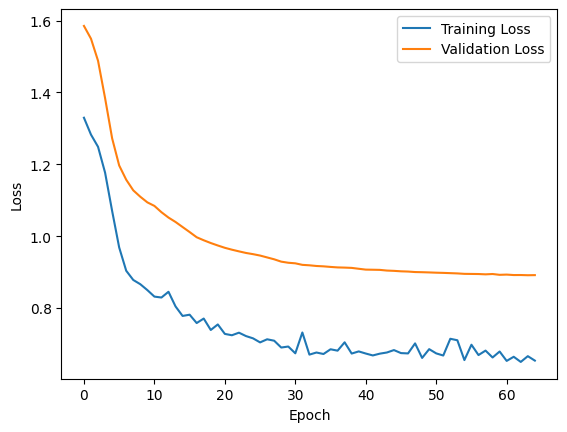

In [1020]:
plt.plot(history["loss"], label="Training Loss")
plt.plot(history["val_loss"], label="Validation Loss")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

## analysis

In [1021]:
test_x_predictions = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - test_x_predictions, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': y_test})
error_df.describe()

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


,Reconstruction_error,True_class
count,400.000000,400.000000
mean,0.887102,0.010000
std,2.557322,0.099623
min,0.041073,0.000000
25%,0.196417,0.000000
50%,0.308455,0.000000
75%,0.576359,0.000000
max,28.197394,1.000000


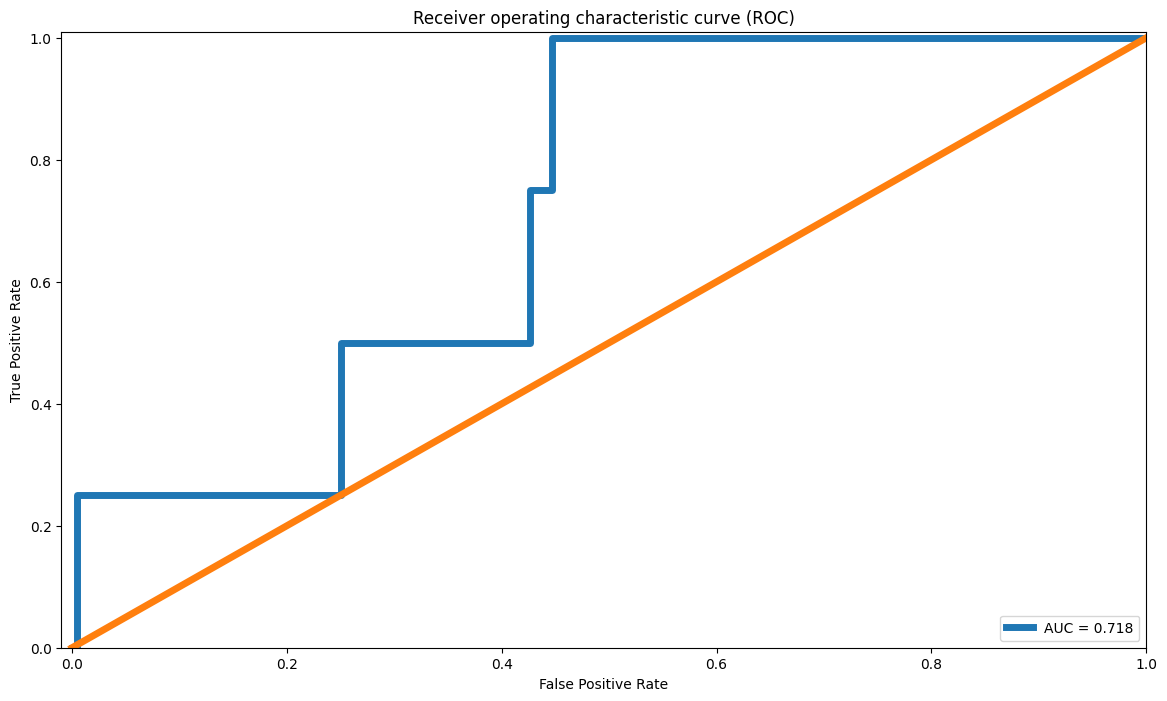

In [1022]:
false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df.True_class,
                                                      error_df.Reconstruction_error)
roc_auc = auc(false_pos_rate, true_pos_rate,)

plt.figure(figsize=(14, 8))
plt.plot(false_pos_rate, true_pos_rate, linewidth=5, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=5)

plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

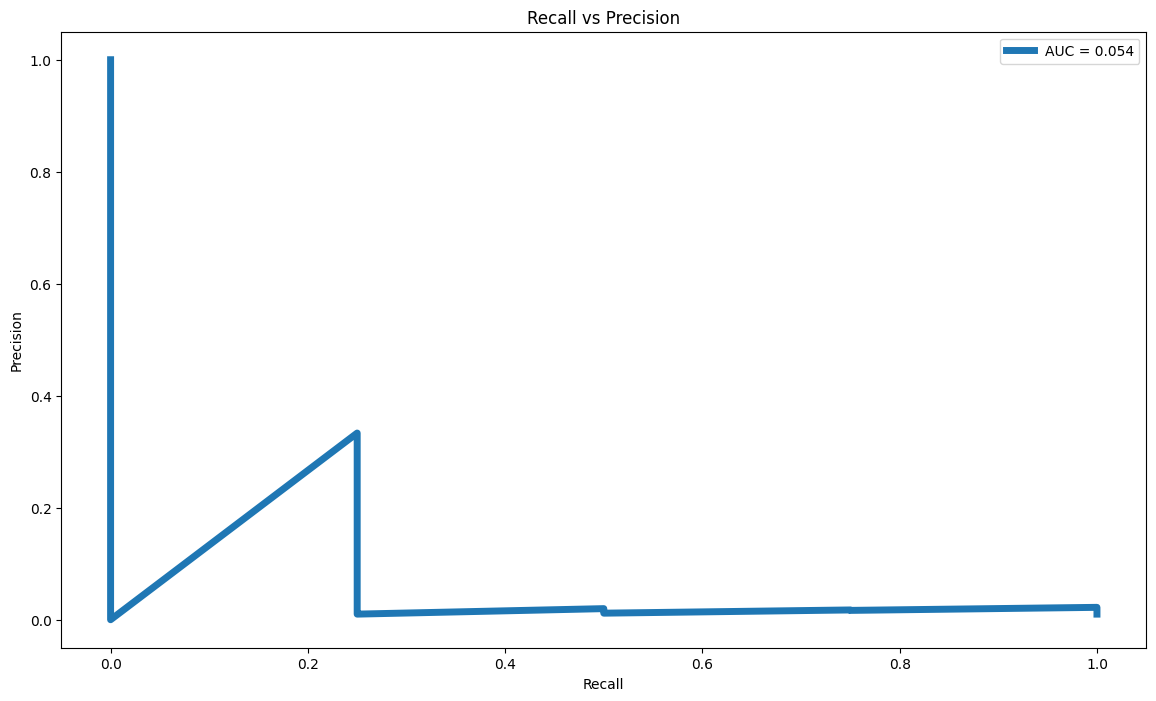

In [1023]:

# calculates precision/recall using reconstruction error as the decision function
# returns: 
# precision_rt: Precision values such that element i is the precision of predictions with 
#               score >= thresholds[i] and the last element is 1.
# recall_rt: Decreasing recall values such that element i is the recall of predictions with 
#           score >= thresholds[i] and the last element is 0.
# threshold_rt = Increasing thresholds on the decision function used to compute
#                precision and recall.
precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class,
                                                               error_df.Reconstruction_error)

pr_auc = auc(recall_rt, precision_rt,)

plt.figure(figsize=(14, 8))
plt.plot(recall_rt, precision_rt, linewidth=5, label='AUC = %0.3f'% pr_auc)
plt.legend(loc='upper right')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

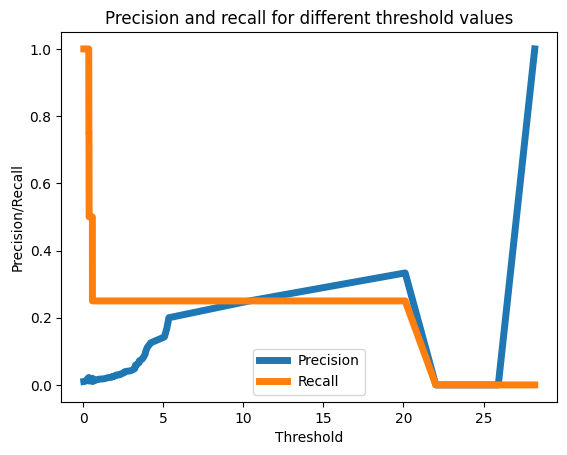

In [1024]:
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=5)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

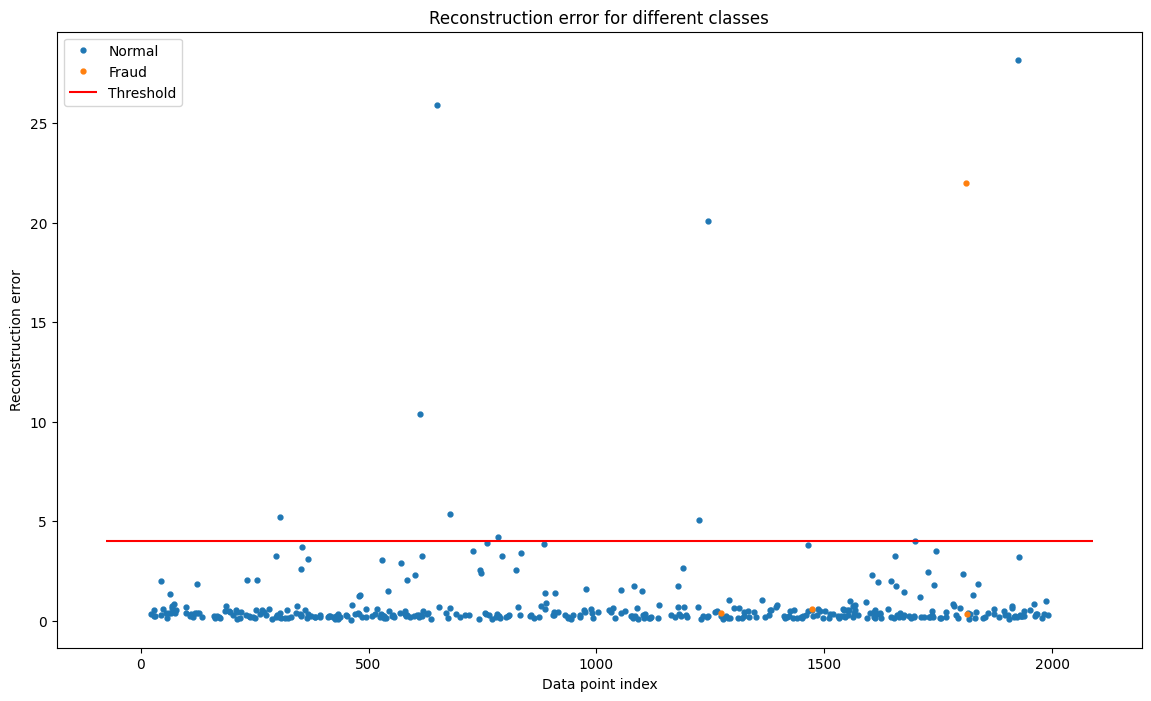

In [1025]:
threshold_fixed = 4
groups = error_df.groupby('True_class')
fig, ax = plt.subplots(figsize=(14, 8))

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1],
          colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()

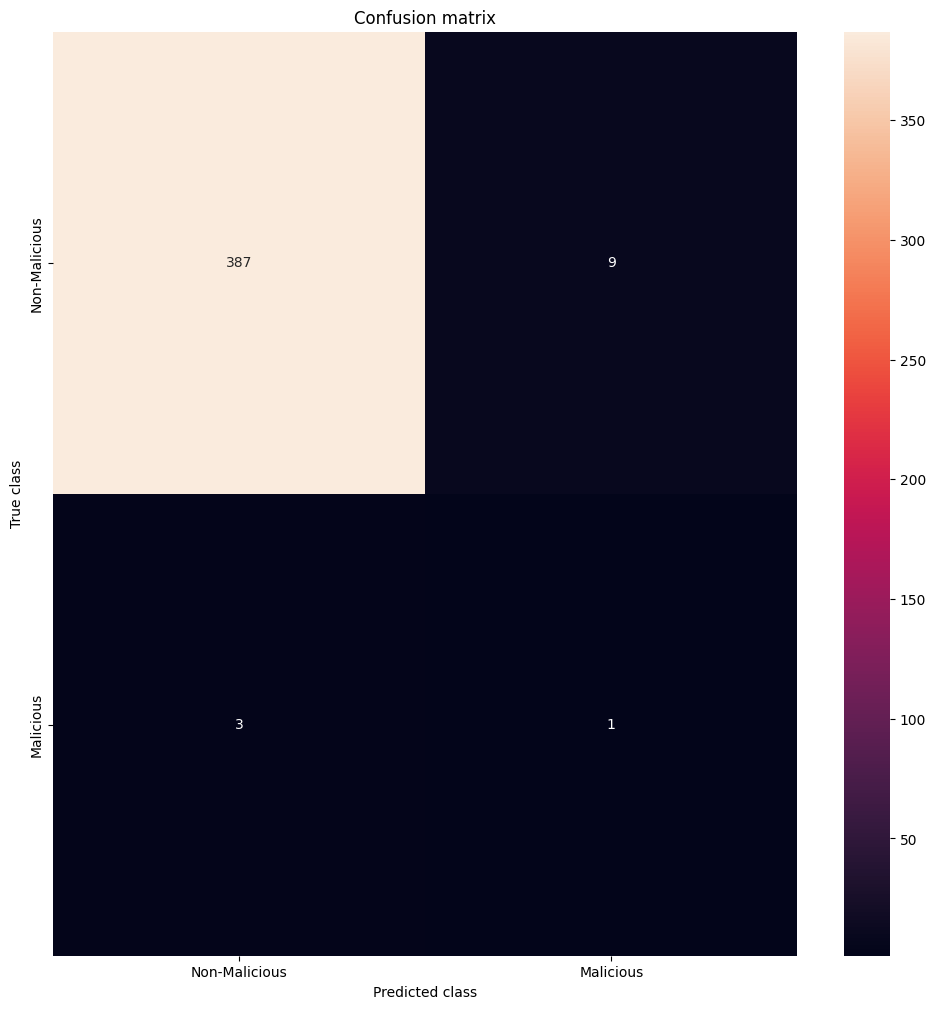

In [1026]:
LABELS = ["Non-Malicious","Malicious"]

# As with autoencoders, it is the assumption that fraud or anomalies will suffer 
# from a detectably high reconstruction error, predicting class as 1 (Fraud)
# if reconstruction error is greater than threshold
pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.True_class, pred_y)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

 1/40 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


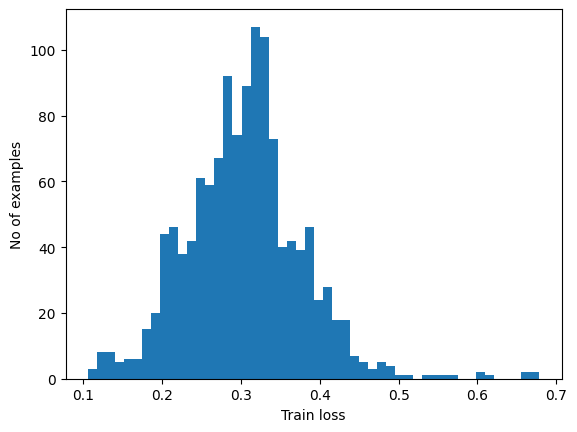

In [1027]:
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [1028]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.377915505346461


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


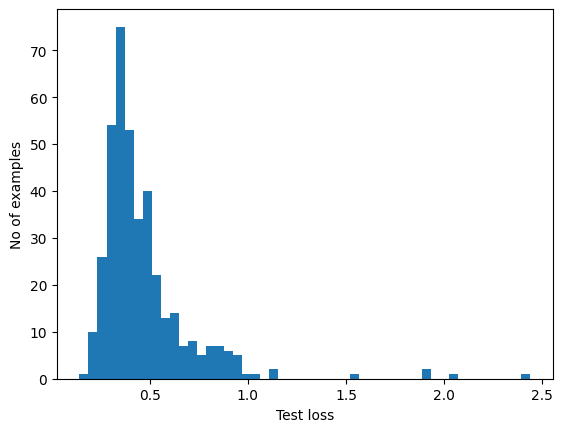

In [1029]:
reconstructions = autoencoder.predict(anomalous_test_data)
test_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)

plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

In [1030]:
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mse(reconstructions, data)
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))

In [1031]:
preds = predict(autoencoder, X_test, threshold)
print_stats(preds, test_labels)

# anything more than >0.9 is good 
# results not great

Accuracy = 0.4
Precision = 0.008333333333333333
Recall = 0.5
